# setup

In [1]:
import xgboost as xgb
import mediapipe as mp
import cv2
import numpy as np
import pandas as pd
import pickle
import random

In [2]:
# Load model
model = xgb.XGBClassifier()
model.load_model("body_lang_model.json")

In [3]:
# Load the LabelEncoder
with open("label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)


In [4]:
# Storing column names
feat_names=model.get_booster().feature_names

# running test

In [ ]:
# Initialize MediaPipe holistic model and drawing utilities
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

# Get screen dimensions (update these if needed)
screen_width = 1920  # Replace with actual screen width
screen_height = 1080  # Replace with actual screen height

# Set window size to 90% of screen size
window_width = int(screen_width * 0.9)
window_height = int(screen_height * 0.9)

# lists for storing predictions and probabilites

preds, probs = [],[]

# Open webcam
cap = cv2.VideoCapture(0)

# Start Holistic Model
with mp_holistic.Holistic(min_detection_confidence=0.7, min_tracking_confidence=0.7) as holistic:
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Convert BGR to RGB for MediaPipe
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        
        # Process frame with holistic model
        results = holistic.process(image)
        
        # Convert RGB back to BGR for OpenCV rendering
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Draw face landmarks
        mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                                  mp_drawing.DrawingSpec(color=(80, 110, 10), thickness=1, circle_radius=1),
                                  mp_drawing.DrawingSpec(color=(80, 256, 121), thickness=1, circle_radius=1))

        # Draw right hand landmarks
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(80, 22, 10), thickness=2, circle_radius=4),
                                  mp_drawing.DrawingSpec(color=(80, 44, 121), thickness=2, circle_radius=2))

        # Draw left hand landmarks
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=2, circle_radius=4),
                                  mp_drawing.DrawingSpec(color=(121, 44, 250), thickness=2, circle_radius=2))

        # Draw pose landmarks
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=4),
                                  mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2))

        # Extract and save landmark coordinates
        try:
            # Define default values for missing landmarks
            missing_pose = [[np.nan, np.nan, np.nan, np.nan]] * 33
            missing_face = [[np.nan, np.nan, np.nan]] * 468
            missing_hand = [[np.nan, np.nan, np.nan]] * 21  # Hands don't have visibility

            # Ensure consistent landmark extraction
            pose = [[lm.x, lm.y, lm.z, lm.visibility] for lm in results.pose_landmarks.landmark] if results.pose_landmarks else missing_pose
            face = [[lm.x, lm.y, lm.z] for lm in results.face_landmarks.landmark] if results.face_landmarks else missing_face
            right_hand = [[lm.x, lm.y, lm.z] for lm in results.right_hand_landmarks.landmark] if results.right_hand_landmarks else missing_hand
            left_hand = [[lm.x, lm.y, lm.z] for lm in results.left_hand_landmarks.landmark] if results.left_hand_landmarks else missing_hand

            # Presence flags
            pose_present= 1 if results.pose_landmarks else 0
            face_present= 1 if results.face_landmarks else 0
            right_hand_present = 1 if results.right_hand_landmarks else 0
            left_hand_present = 1 if results.left_hand_landmarks else 0

            # Flatten lists
            pose_row = list(np.array(pose).flatten())
            face_row = list(np.array(face).flatten())
            right_hand_row = list(np.array(right_hand).flatten())
            left_hand_row = list(np.array(left_hand).flatten())

            # Combine all landmark data
            row = [pose_present] + pose_row + [face_present] + face_row + [right_hand_present] + right_hand_row + [left_hand_present] + left_hand_row
            
            # Make detections
            X = pd.DataFrame([row],columns=feat_names)
            body_language_class = model.predict(X)
            body_language_class = label_encoder.inverse_transform(body_language_class)
            body_language_prob = model.predict_proba(X)
            #print(body_language_class[0], np.max(body_language_prob)*100)

            # optimizations
            if(body_language_class=="smiling"):
                if random.random() < 0.7:
                    body_language_class = ['idle']
            if(body_language_class in ["shrugging","pointing_finger"]):
                if random.random() < 0.4:
                    body_language_class = ['gesturing']
            
            #store predictions
            preds.append(str(body_language_class[0]))
            probs.append(round(np.max(body_language_prob)*100,2))

            # Grab ear coords
            coords = tuple(np.multiply(
                            np.array(
                                (results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_EAR].x, 
                                 results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_EAR].y))
                        , [640,480]).astype(int))
            
            #create box to display class
            cv2.rectangle(image, 
                          (coords[0], coords[1]+5), 
                          (coords[0]+len(body_language_class)*150, coords[1]-30), 
                          (245, 117, 16), -1)
            cv2.putText(image, body_language_class[0], coords, 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA)
            
            # Get status box
            cv2.rectangle(image, (0,0), (250, 60), (245, 117, 16), -1)
            
            # Display Class
            cv2.putText(image, 'CLASS'
                        , (95,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
            cv2.putText(image, str(body_language_class[0])
                        , (90,40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA)
            
            # Display Probability
            cv2.putText(image, 'PROB'
                        , (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
            cv2.putText(image, str(round(np.max(body_language_prob)*100,2))
                        , (10,40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA)

        except Exception as e:
            print(f"Error processing frame: {e}")

        # Display the output
        cv2.namedWindow('Raw Webcam Feed', cv2.WINDOW_NORMAL)
        cv2.resizeWindow('Raw Webcam Feed', window_width, window_height)
        #image=cv2.flip(image,1)
        cv2.imshow('Raw Webcam Feed', image)

        # Stop when 'q' is pressed or window is closed
        if cv2.waitKey(10) & 0xFF == ord('q') or cv2.getWindowProperty('Raw Webcam Feed', cv2.WND_PROP_VISIBLE) < 1:
            break

# Release resources
cap.release()
cv2.destroyAllWindows()


In [12]:
result_df = pd.DataFrame({"Predicted Class": preds, "Probability": probs})
pd.set_option("display.max_rows", None)
print(result_df)

      Predicted Class  Probability
0                idle        74.50
1      covering_mouth        53.33
2      covering_mouth        51.30
3                idle        54.08
4             smiling        55.54
5             smiling        51.09
6                idle        57.26
7             smiling        63.15
8             smiling        53.10
9                idle        60.22
10            smiling        53.63
11            smiling        80.52
12               idle        86.39
13     covering_mouth        51.50
14               idle        88.78
15               idle        79.81
16               idle        74.21
17            smiling        68.15
18            smiling        78.83
19            smiling        85.54
20            smiling        84.06
21               idle        87.40
22            smiling        80.88
23               idle        85.53
24               idle        73.16
25               idle        73.03
26            smiling        36.85
27           thinkin

# analysis of predicted results

C:\Users\santh\AppData\Local\Temp\ipykernel_33388\2273350544.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=result_df["Predicted Class"], order=result_df["Predicted Class"].value_counts().index, palette="cubehelix")


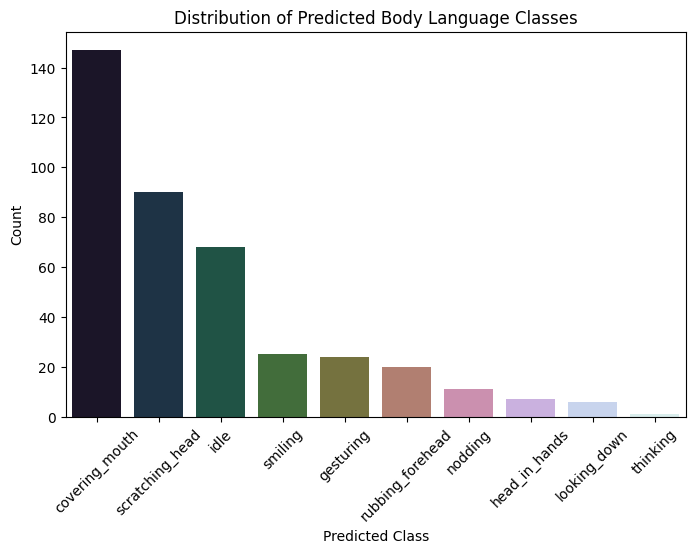

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(x=result_df["Predicted Class"], order=result_df["Predicted Class"].value_counts().index, palette="cubehelix")
plt.title("Distribution of Predicted Body Language Classes")
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


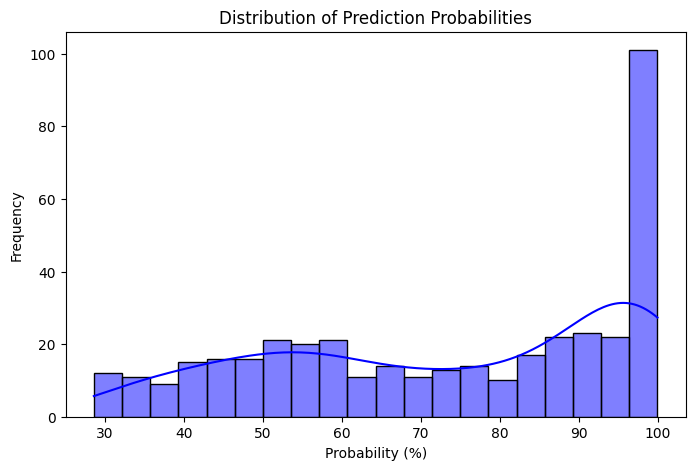

In [12]:
plt.figure(figsize=(8, 5))
sns.histplot(result_df["Probability"], bins=20, kde=True, color="blue")
plt.title("Distribution of Prediction Probabilities")
plt.xlabel("Probability (%)")
plt.ylabel("Frequency")
plt.show()


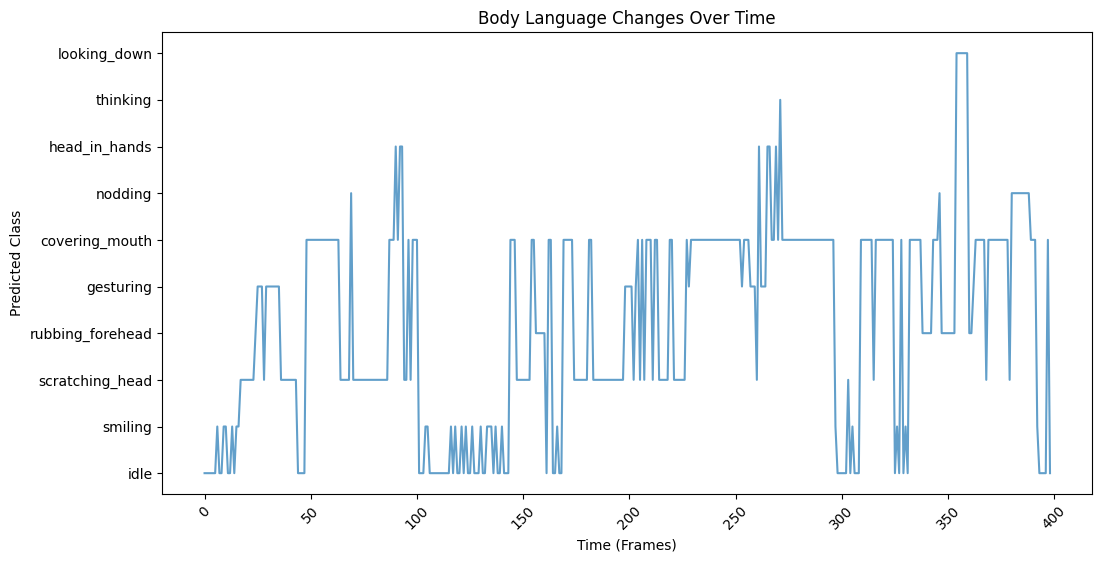

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(result_df.index, result_df["Predicted Class"], linestyle="-", alpha=0.7)
plt.title("Body Language Changes Over Time")
plt.xlabel("Time (Frames)")
plt.ylabel("Predicted Class")
plt.xticks(rotation=45)
plt.show()


C:\Users\santh\AppData\Local\Temp\ipykernel_33388\273161898.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Class", y="Duration", data=behavior_df, palette="cubehelix",errorbar=None)


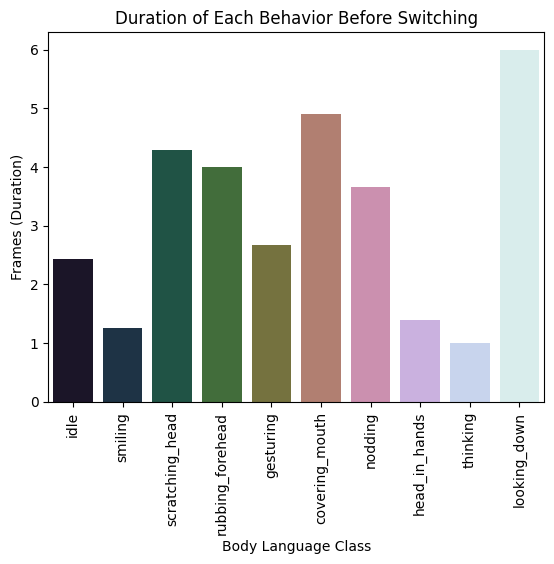

In [14]:
from itertools import groupby

durations = [(key, len(list(group))) for key, group in groupby(result_df["Predicted Class"])]

behavior_df = pd.DataFrame(durations, columns=["Class", "Duration"])
sns.barplot(x="Class", y="Duration", data=behavior_df, palette="cubehelix",errorbar=None)
plt.title("Duration of Each Behavior Before Switching")
plt.xlabel("Body Language Class")
plt.ylabel("Frames (Duration)")
plt.xticks(rotation=90)
plt.show()


# scoring

In [7]:
# Define weights for each pose (adjust as necessary)

pose_weights = {
    "gesturing": 0.8,
    "thinking": 0.6,
    "steepling_fingers": 0.7,
    "crossing_arms": 0.5,
    "covering_mouth": 0.4,
    "hand_on_neck": 0.6,
    "yawning": 0.1,
    "scratching_head": 0.3,
    "looking_down": 0.3,
    "smiling": 0.8,
    "rubbing_forehead": 0.3,
    "hair_tucking": 0.4,
    "nail_biting": 0.1,
    "folding_palms": 0.3,
    "idle": 0.5,
    "shaking_head": 0.5,
    "nodding": 0.7,
    "pointing_finger": 0.5,
    "head_in_hands": 0.1,
    "sitting_straight": 0.9,
    "touching_ear": 0.4,
    "slouching": 0.2,
    "shrugging": 0.4,
    "tugging_collar": 0.3,
    "waving": 0.7,
    "shaking_fist": 0.1
}

In [8]:
# Poses that should have diminishing returns if overused

diminishing_classes = {"gesturing", "nodding", "steepling_fingers", "smiling", "idle", "thinking", "crossing_arms", "hand_on_neck", "shaking_head", "pointing_finger", "covering_mouth", "waving"}

In [13]:
# Function to compute the structured breakdown and score

def compute_interview_analysis(result_df):
    total_frames = result_df.shape[0]

    # Step 1: Compute Pose Distribution (%)
    pose_counts = result_df["Predicted Class"].value_counts(normalize=True) * 100
    result_df["Pose_Percentage"] = result_df["Predicted Class"].map(pose_counts)

    # Step 2: Adjust for overuse (Diminishing Returns for Certain Poses)
    def adjust_weight(pose, weight, percentage):
        if pose in diminishing_classes:
            reduction_factor = min(0.5, percentage / 50)  # Reduce if over 50% occurrence
            return weight * (1 - reduction_factor)
        return weight

    result_df["Adjusted_Weight"] = result_df.apply(lambda row: adjust_weight(
        row["Predicted Class"], pose_weights.get(row["Predicted Class"], 0.5), row["Pose_Percentage"]
    ), axis=1)

    # Step 3: Weight by Model Confidence (Probability)
    result_df["Confidence_Weighted_Score"] = result_df["Probability"] * result_df["Adjusted_Weight"]

    # Step 4: Apply Smoothing to Reduce Sensitivity to Short-Term Errors
    result_df["Smoothed_Score"] = result_df["Confidence_Weighted_Score"].rolling(window=5, min_periods=1).mean()

    # Step 5: Weight by Duration (Pose Distribution % acts as duration weight)
    result_df["Duration_Weighted_Score"] = result_df["Smoothed_Score"] * result_df["Pose_Percentage"] / 100

    # Step 6: Compute Final Score
    max_possible_score = sum(pose_weights.values()) * 100  # Maximum theoretical score
    final_score = (result_df["Duration_Weighted_Score"].sum() / max_possible_score) * 100
    final_score = min(final_score, 100)  # Cap at 100

    # Step 7: Generate Structured Breakdown for LLM Analysis
    analysis = {
    "final_score": round(final_score, 2),
    "pose_distribution": {k: round(v, 2) for k, v in pose_counts.to_dict().items()},
    "duration_weighted_scores": {k: round(v, 2) for k, v in result_df.groupby("Predicted Class")["Duration_Weighted_Score"].sum().to_dict().items()},
    }

    return analysis, result_df


In [14]:
analysis, scored_df = compute_interview_analysis(result_df)
print(analysis)  # This structured dictionary can be fed to an LLM

{'final_score': 70.2, 'pose_distribution': {'covering_mouth': 37.39, 'rubbing_forehead': 21.62, 'scratching_head': 8.56, 'looking_down': 8.56, 'idle': 6.76, 'smiling': 6.76, 'touching_ear': 4.95, 'gesturing': 4.5, 'thinking': 0.9}, 'duration_weighted_scores': {'covering_mouth': 487.81, 'gesturing': 18.15, 'idle': 36.5, 'looking_down': 40.35, 'rubbing_forehead': 137.85, 'scratching_head': 35.86, 'smiling': 37.2, 'thinking': 0.5, 'touching_ear': 13.08}}


# generating report

In [19]:
def format_analysis_for_llm(analysis):

    final_score = analysis.get("final_score", "N/A")
    pose_distribution = analysis.get("pose_distribution", {})
    duration_weighted_scores = analysis.get("duration_weighted_scores", {})

    # Format pose distribution
    pose_dist_str = "\n".join([f"- {pose}: {percentage:.2f}%" for pose, percentage in pose_distribution.items()])

    # Format duration-weighted scores
    duration_scores_str = "\n".join([f"- {pose}: {score:.2f}" for pose, score in duration_weighted_scores.items()])

    formatted_string = f"""Interview Analysis Summary:

        Final Score: {final_score:.2f}/100

        Pose Distribution (% of time spent in each pose):
        {pose_dist_str}

        Duration-Weighted Scores (Higher values indicate more impact on assessment):
        {duration_scores_str}
    """

    return formatted_string

In [20]:
formatted_analysis = format_analysis_for_llm(analysis)
print(formatted_analysis)

Interview Analysis Summary:

        Final Score: 100.00/100

        Pose Distribution (% of time spent in each pose):
        - covering_mouth: 36.84%
- scratching_head: 22.56%
- idle: 17.04%
- smiling: 6.27%
- gesturing: 6.02%
- rubbing_forehead: 5.01%
- nodding: 2.76%
- head_in_hands: 1.75%
- looking_down: 1.50%
- thinking: 0.25%

        Duration-Weighted Scores (Higher values indicate more impact on assessment):
        - covering_mouth: 962.52
- gesturing: 37.27
- head_in_hands: 1.87
- idle: 361.41
- looking_down: 2.11
- nodding: 12.26
- rubbing_forehead: 17.52
- scratching_head: 451.19
- smiling: 61.45
- thinking: 0.03
    


In [21]:
from g4f.client import Client

def body_language_report(analysis):
    prompt = "Given below is a summary of a user's mock interview that tests their body language. You are an expert on interviews. Analyze the provided information critically, and provide helpful, actionable tips on how the user can improve their body language during interviews and thus their score.\n answer format: \n'what you did right:' followed by a brief bulleted list of things the user did right \n'Tips for improvement:' followed by a brief bulleted list of tips, outlining concisely in each tip what the user can improve, why it's relevant from an interview standpoint, and how the user can improve it. \neach tip should be 1 sentence long. Do not reply in markdown format, just give me clean text with points\n{an}"
    client = Client()
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt.format(an=analysis)}],
    )

    #print(prompt)
    
    # Capture the response text and split into keywords
    result = response.choices[0].message.content
    return result

In [213]:
report=body_language_report(formatted_analysis)
print(report)

What you did right:
- Your gestures, although minimal, were appropriate and relevant when you used them.
- You maintained some eye contact, even though looking down was noted; this suggests you are aware of the importance of engagement.

Tips for improvement:
- Reduce the amount of time spent with your head in your hands, as it conveys a lack of confidence and can distract interviewers from your message; try to sit up straight and use an open posture to project confidence. 
- Avoid covering your mouth when speaking, as it may be interpreted as a sign of uncertainty; practice speaking clearly without obstruction to enhance your credibility. 
- Increase your gesturing to emphasize key points, as this can help convey enthusiasm and engagement; you can rehearse your responses while incorporating natural gestures to become more comfortable. 
- Work on maintaining eye contact to build rapport and display confidence; practice by engaging in conversations with others while consciously maintain

C:\Users\theon\AppData\Local\Programs\Python\Python311\Lib\asyncio\events.py:84: UserWarning: Curlm alread closed! quitting from process_data
  self._context.run(self._callback, *self._args)
